# Comparative Analysis of CNN Architectures

Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

Dataset Loader

In [2]:
# Dataset Loader

def load_dataset(dataset="CIFAR10", batch_size=128):

    if dataset == "MNIST":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        trainset = torchvision.datasets.MNIST(root="./data", train=True,
                                             download=True, transform=transform)
        testset = torchvision.datasets.MNIST(root="./data", train=False,
                                            download=True, transform=transform)
        num_classes = 10

    elif dataset == "CIFAR10":
        transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        trainset = torchvision.datasets.CIFAR10(root="./data", train=True,
                                               download=True, transform=transform_train)
        testset = torchvision.datasets.CIFAR10(root="./data", train=False,
                                              download=True, transform=transform_test)
        num_classes = 10

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False)

    return trainloader, testloader, num_classes


Loss Functions

In [3]:
# Loss Functions

class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        ce_loss = self.ce(outputs, targets)
        pt = torch.exp(-ce_loss)
        return ((1 - pt) ** self.gamma) * ce_loss


Model Loader

In [8]:
def get_model(name, num_classes):

    if name == "VGG":
        model = models.vgg16(weights=None)
        model.classifier[6] = nn.Linear(4096, num_classes)

    elif name == "AlexNet":
        model = models.alexnet(weights=None)
        model.classifier[6] = nn.Linear(4096, num_classes)

    elif name == "ResNet50":
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif name == "ResNet18":   # ✅ ADD THIS
        model = models.resnet18(weights=None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif name == "MobileNet":
        model = models.mobilenet_v2(weights=None)
        model.classifier[1] = nn.Linear(model.last_channel, num_classes)

    else:
        raise ValueError("Model not supported")

    return model


Training

In [9]:
# Training + Early Stopping

def evaluate(model, testloader, loss_fn):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    correct, total = 0, 0
    total_loss = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total, total_loss / len(testloader)


def train_model(model, trainloader, testloader, loss_fn, optimizer,
                epochs=20, patience=3):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_loss = float("inf")
    stop_counter = 0

    for epoch in range(epochs):

        model.train()
        correct, total = 0, 0

        loop = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(),
                             acc=100 * correct / total)

        train_acc = 100 * correct / total
        test_acc, test_loss = evaluate(model, testloader, loss_fn)

        print(f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

        # Early Stopping
        if test_loss < best_loss:
            best_loss = test_loss
            stop_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            stop_counter += 1

        if stop_counter >= patience:
            print("Early stopping triggered!")
            break


t-SNE Visualization

In [10]:
# t-SNE Visualization

def tsne_visualization(model, testloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    features, labels_list = [], []

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            outputs = model(images)

            features.append(outputs.cpu().numpy())
            labels_list.append(labels.numpy())

            if len(features) > 10:
                break

    features = np.concatenate(features)
    labels_list = np.concatenate(labels_list)

    tsne = TSNE(n_components=2)
    reduced = tsne.fit_transform(features)

    plt.figure(figsize=(8,6))
    plt.scatter(reduced[:,0], reduced[:,1], c=labels_list, cmap="tab10")
    plt.title("t-SNE Feature Clustering")
    plt.show()


Epoch 1/20: 100%|██████████| 391/391 [01:02<00:00,  6.26it/s, acc=26.4, loss=0.83]


Train Acc: 26.37% | Test Acc: 40.39%


Epoch 2/20: 100%|██████████| 391/391 [01:02<00:00,  6.24it/s, acc=44.6, loss=0.757]


Train Acc: 44.60% | Test Acc: 52.58%


Epoch 3/20: 100%|██████████| 391/391 [01:01<00:00,  6.32it/s, acc=53.3, loss=0.576]


Train Acc: 53.35% | Test Acc: 58.27%


Epoch 4/20: 100%|██████████| 391/391 [01:01<00:00,  6.31it/s, acc=59.7, loss=0.289]


Train Acc: 59.69% | Test Acc: 62.72%


Epoch 5/20: 100%|██████████| 391/391 [01:02<00:00,  6.27it/s, acc=63.7, loss=0.458]


Train Acc: 63.72% | Test Acc: 67.41%


Epoch 6/20: 100%|██████████| 391/391 [01:02<00:00,  6.25it/s, acc=67.3, loss=0.268]


Train Acc: 67.33% | Test Acc: 69.37%


Epoch 7/20: 100%|██████████| 391/391 [01:02<00:00,  6.27it/s, acc=70.5, loss=0.476]


Train Acc: 70.51% | Test Acc: 72.54%


Epoch 8/20: 100%|██████████| 391/391 [01:02<00:00,  6.27it/s, acc=72.4, loss=0.144]


Train Acc: 72.42% | Test Acc: 73.02%


Epoch 9/20: 100%|██████████| 391/391 [01:02<00:00,  6.28it/s, acc=74.5, loss=0.151]


Train Acc: 74.51% | Test Acc: 74.19%


Epoch 10/20: 100%|██████████| 391/391 [01:01<00:00,  6.31it/s, acc=76, loss=0.195]


Train Acc: 76.04% | Test Acc: 76.28%


Epoch 11/20: 100%|██████████| 391/391 [01:01<00:00,  6.31it/s, acc=77.3, loss=0.122]


Train Acc: 77.33% | Test Acc: 76.15%


Epoch 12/20: 100%|██████████| 391/391 [01:01<00:00,  6.34it/s, acc=78.7, loss=0.143]


Train Acc: 78.73% | Test Acc: 77.55%


Epoch 13/20: 100%|██████████| 391/391 [01:01<00:00,  6.34it/s, acc=79.6, loss=0.084]


Train Acc: 79.59% | Test Acc: 78.65%


Epoch 14/20: 100%|██████████| 391/391 [01:01<00:00,  6.34it/s, acc=80.6, loss=0.0307]


Train Acc: 80.62% | Test Acc: 79.19%


Epoch 15/20: 100%|██████████| 391/391 [01:01<00:00,  6.34it/s, acc=81.3, loss=0.115]


Train Acc: 81.32% | Test Acc: 79.00%


Epoch 16/20: 100%|██████████| 391/391 [01:01<00:00,  6.35it/s, acc=82.6, loss=0.0749]


Train Acc: 82.58% | Test Acc: 79.35%


Epoch 17/20: 100%|██████████| 391/391 [01:01<00:00,  6.33it/s, acc=83.2, loss=0.0872]


Train Acc: 83.19% | Test Acc: 79.98%


Epoch 18/20: 100%|██████████| 391/391 [01:01<00:00,  6.32it/s, acc=83.9, loss=0.0455]


Train Acc: 83.93% | Test Acc: 79.48%


Epoch 19/20: 100%|██████████| 391/391 [01:01<00:00,  6.36it/s, acc=84.2, loss=0.109]


Train Acc: 84.21% | Test Acc: 79.27%


Epoch 20/20: 100%|██████████| 391/391 [01:01<00:00,  6.37it/s, acc=85.6, loss=0.0247]


Train Acc: 85.64% | Test Acc: 81.59%


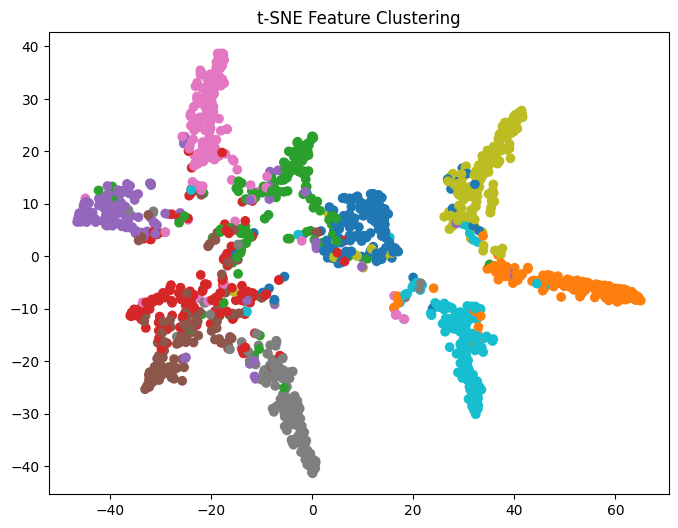

In [11]:
# Run Experiment

dataset = "CIFAR10"
model_name = "VGG"

trainloader, testloader, num_classes = load_dataset(dataset)

model = get_model(model_name, num_classes)

loss_fn = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

train_model(model, trainloader, testloader, loss_fn, optimizer,
            epochs=20, patience=3)

tsne_visualization(model, testloader)